<a href="https://colab.research.google.com/github/gerritgr/pokemon_diffusion/blob/main/Practical_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokemon Diffusion

Repository for the practical projecto the [*Deep Generative Diffusion Models*](https://mosi.uni-saarland.de/lectures/22_2_deep_diffusion/) Seminar at Saarland University.

## Rules ⚖️ 

### Formalities 📝 

* The goal is to implement an end-to-end diffusion model on the CelebFace dataset.
* You work alone or in groups of two.
* Plagiarism will get you expelled from the seminar and potentially exmatriculated. However, you can discuss solutions with your fellow students and take inspiration from open-source implementations (see references). 
* You can also copy&pase small code snippets if they are clearly indicated.
* We recommend Python + PyTorch for the implementation. If you want to use something else, please reach out to us. 
* Your code should run on Google Colab and normal desktop computers with minimal setup effort.
* We will invite each team to explain their code in an individual meeting. You (resp. both of you) should be able to explain the code in detail and justify design choices.
* Submit your results via e-mail to Gerrit.

### How to Pass 🎓

* To pass, you need to provide a (in a reasonable sense) technically correct implementation of a forward and backward process. You will not be judged on the visual quality of the generated images.
* In addition, you should generate animations (e.g., gifs) of the forward and backward process to illustrate what is going on during training and data generation (cf. *one_step_forward()* function).
* Comment your code extensively and assign proper names to your functions, variables, and classes. 
* Set seeds to make your code deterministic and save the final weights. 
* You should also visually verify that the forward process ends in a standard normal distribution by providing a reasonable visualization (analogously to *color_distribution_original_images.png*).
* We recommend following the denoising diffusion paradigm. When you want to use score-based or SDE methods, you can do so as well. 
* If you make very unconventional design choices, you will need to be able to justify them. 
* Do you see any problems with your implementations or room to improve? Explain in a short paragraph (can be part of the notebook). 
* You can use this notebook or use your code from scratch. 

### Notes on the Reference Implementation 💻 

* You will probably need to activate the GPU of Colab and use batched images when you want to be able to generate nice images (for passing, this is not necessary, though)
* We use a simple linear schedular and batch size of 256. 
* We predict the original image and not the noise. 
* We use a Unet, inspired by _The Annotated Diffusion Model_.
* We run at least for 1000 epochs.
* The visual quality strongly depends on the complexity of the Unet. Do not worry if your generated images look more like blobs than actual Pokomen. For passing, a minimal Unet or Autoencoder is enough. 
* Of course, you can always test other (larger) datasets to play around with.

### Bonus 🏆

For a bonus (0.3 on your final grade), you can extend the implementation in any creative way. Possibilities include:
* Smart data augmentation, extending the data set, or pre-training
* Conditioning (e.g. on the Pokemon *type*)
* Testing different network architectures, schedulers, or time-embeddings and reporting the findings.
* Using a latent diffusion approach instead of diffusion in the RGB/image space.

If you have any other idea you think is worth investigating: try it out!


### References 📚
Preliminaries 💡 
* [10 tricks for a better Google Colab experience](https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82)
* [Youtube: Deep Learning With PyTorch - Full Course (in case you need some PyTorch refreshments)](https://www.youtube.com/watch?v=c36lUUr864M&ab_channel=PatrickLoeber)
* [UvA PyTorch Tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html)

Diffusion 🧨
* [Tiny Diffusion Repo by tanelp (minimal example of a 2D diffusion)](https://github.com/tanelp/tiny-diffusion)
* [Youtube: Diffusion models from scratch in PyTorch](https://www.youtube.com/watch?v=a4Yfz2FxXiY&t=644s)
* [Youtube: Diffusion Models | PyTorch Implementation](https://www.youtube.com/watch?v=TBCRlnwJtZU&ab_channel=Outlier)
* [The Annotated Diffusion Model](https://huggingface.co/blog/annotated-diffusion)
* [U-Net: A PyTorch Implementation in 60 lines of code](https://amaarora.github.io/2020/09/13/unet.html)

Pokemon 🐲
* [Pokemon Images Dataset on Kaggle](https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset)
* [PokeGAN: Generating Fake Pokemon with a Generative Adversarial Network](https://blog.jovian.com/pokegan-generating-fake-pokemon-with-a-generative-adversarial-network-f540db81548d)
* [pokemon-ga by Zhenye Na (contains the dataset we are using)](https://github.com/Zhenye-Na/pokemon-gan)


## Files 📁
* `color_distribution_original_images.png`: RGB value disribution of the trainings data
* `dataset_summary.png`: Some (augmented) images from the trainings data
* `forward_animate.gif`: Animation of an (incorrect) forward process. 
* `forward_grid.png`: Imagegrid of an (incorrect) forward process. 
* `reverse_process_reference_epoch_X.gif`: Examples of the reverse process of the reference implementation after X epochs
* `color_distribution_normal_reference.png`: RGB value disribution of the trainings _after_ the forward process

# Setup

### Downloading the Data

In [ ]:
# If we are on Colab, we need to get the data
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !git clone https://github.com/gerritgr/pokemon_diffusion
  #!mkdir pokemon
  !cp -r pokemon_diffusion/pokemon pokemon/

fatal: destination path 'pokemon_diffusion' already exists and is not an empty directory.


### Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100 # Set this to 300 to get better image quality
from PIL import Image # We use PIL to load images
import seaborn as sns
import imageio # to generate .gifs

# always good to have
import glob, random, os
import numpy as np

# the typical pytorch imports
import torch
import torchvision
from torchvision import transforms 
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch.nn import Conv2d
from torch.optim import Adam

### Hyperparameters

These are just random hyperparameters, play around with them.

In [ ]:
IMG_SIZE = 32   # We assume images are square with IMG_SIZE*IMG_SIZE pixels, 16x16 works, too.
EPOCHS = 5000
BATCH_SIZE = 256
TIMESTEPS = 100

# On Colab, go to Runtime -> Change runtime type to switch to GPU 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHANNELS = 3  # We use RGB images
DEVICE

device(type='cuda')

### Seeds
... to make everyting deterministic.

In [ ]:
np.random.seed(42)
torch.random.manual_seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
os.environ['PYTHONHASHSEED'] = '42'
torch.backends.cudnn.deterministic = True

### Utils

We start by defining some friendly little helpers. 

In [ ]:
def image_to_tensor(image):
    """Convert a PIL image to a PyTorch tensor.

    Args:
        image (PIL.Image): The image to be converted.

    Returns:
        torch.Tensor: The converted PyTorch tensor.
    """
    # Define the image transformation pipeline
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Lambda(lambda t: (t - 0.5) * 2.)
    ])

    # Apply the transformation pipeline to the image
    return transform(image)


def tensor_to_img(tensor):
    """Convert a PyTorch tensor to a PIL image.

    Args:
        tensor (torch.Tensor): The PyTorch tensor to be converted.

    Returns:
        PIL.Image: The converted PIL image.
    """
    # Define the tensor transformation pipeline
    transform = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1.) / 2.),
        transforms.Lambda(lambda t: torch.clamp(t, min=0., max=1.)),
        transforms.ToPILImage()
    ])

    # Apply the transformation pipeline to the tensor
    return transform(tensor)


def show_from_image_list(img_list, img_num=10, filename=None):
    """Show a grid of images from a list of images. Sample uniformly spaced images.
        (Alternativly, use make_grid from torchvision.utils)

    Args:
        img_list (list): The list of images to be displayed. Can be PIL or image tensors.
        img_num (int, optional): The number of images to be displayed. Default is 10.
        filename (str, optional): The name of the file to save the plot to. If None, the plot will not be saved. Default is None.
    """
    # Ensure that the number of images to be displayed is less than or equal to the number of images in the list
    img_num = min(len(img_list), img_num)

    # Get the index of the images to be displayed
    img_num_index = np.linspace(0, len(img_list)-1.0, num=img_num).astype(int)

    # Clear the current figure (if there is any)
    plt.clf()

    # Create a figure with 1 row and `img_num` columns
    fig, ax = plt.subplots(1, img_num, figsize=(15, 15), gridspec_kw={'width_ratios': [1] * img_num})

    # Iterate through the images to be displayed
    for i, idx in enumerate(img_num_index):
        img_i = img_list[idx]

        # Check if the image is a PyTorch tensor and convert it to PIL
        if isinstance(img_i, torch.Tensor):
            img_i = tensor_to_img(img_i)

        # Display the image
        ax[i].imshow(img_i)
        ax[i].axis('off')

    # Save the plot to a file if the filename is provided
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()


# Defining the Dataset and Loader

First, we need to create a `Dataset` and a `DataLoader` containing the images (currently in the image folder). This is PyTorch best practice.

The `Dataset` provides access to individual data samples/images  (also providing on-the-fly image augmentation). The `Dataloader` enables efficient loading of the data in mini-batches (also providing randomization).

We build our own `Datset` class that loads the images from disk and stores them in PyTorch tensors of shape $(3, \text{IMG_SIZE}, \text{IMG_SIZE})$ with values between $-1$ and $1$.


In [ ]:
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset


class ImageDataset(Dataset):
  """A dataset for images that supports on-the-fly transformations (i.e., augmentations).

  Args:
      imgpaths (str, optional): The path pattern for the images. Default is "pokemon/*png".
  """

  def __init__(self, img_paths="pokemon/*png"):

    # You can/should play around with these. Which of the augmantation make sense? 
    self.on_the_fly_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(torch.nn.ModuleList([transforms.RandomCrop(int(IMG_SIZE*0.8)),]), p=0.2),
    transforms.RandomAutocontrast(p=0.1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomErasing(p=0.2),
    transforms.Lambda(lambda t: torch.clamp(t, min=-1., max=1.)),
    ])

    self.img_list = list()
    for img_path in glob.glob(img_paths):
      # Turn the transparent part in the image to white following 
      # https://stackoverflow.com/questions/50898034/how-replace-transparent-with-a-color-in-pillow
      image = Image.open(img_path)
      rgba_image = Image.new("RGBA", image.size, "WHITE")
      rgba_image.paste(image, (0, 0), image)   
      rgb_image = rgba_image.convert('RGB')

      # Convert the PIL image to a tensor, where each value is in [-1,1].
      img_as_tensor = image_to_tensor(rgb_image)
      self.img_list.append(img_as_tensor)

  def __getitem__(self, index):
    """Get an image tensor from the dataset with on-the-fly transformation.

    Args:
        index (int): The index of the image tensor in the dataset.

    Returns:
        torch.Tensor: The image tensor with on-the-fly transformation.
    """
    img = self.img_list[index]
    img = self.on_the_fly_transform(img)

    return img
  
  def get_pil_image(self, index, with_random_augmentation=True):
    """Get a PIL image from the dataset with or without on-the-fly transformation.

    Args:
        index (int): The index of the PIL image in the dataset.
        with_random_augmentation (bool, optional): Whether to apply on-the-fly transformation. Default is True.

    Returns:
        PIL.Image: The PIL image with or without on-the-fly transformation.
    """
    if with_random_augmentation:
      return tensor_to_img(self.__getitem__(index))
    return tensor_to_img(self.img_list[index])

  def __len__(self):
    return len(self.img_list)


dataset = ImageDataset()

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Note hat just grabbing an image from the dataset adds a random image augmentation.
# Generally speaking, this will be False.
torch.all(dataset[0] == dataset[0])  # torch.all test if all entries are True

tensor(False)

### Inspecting the Dataset

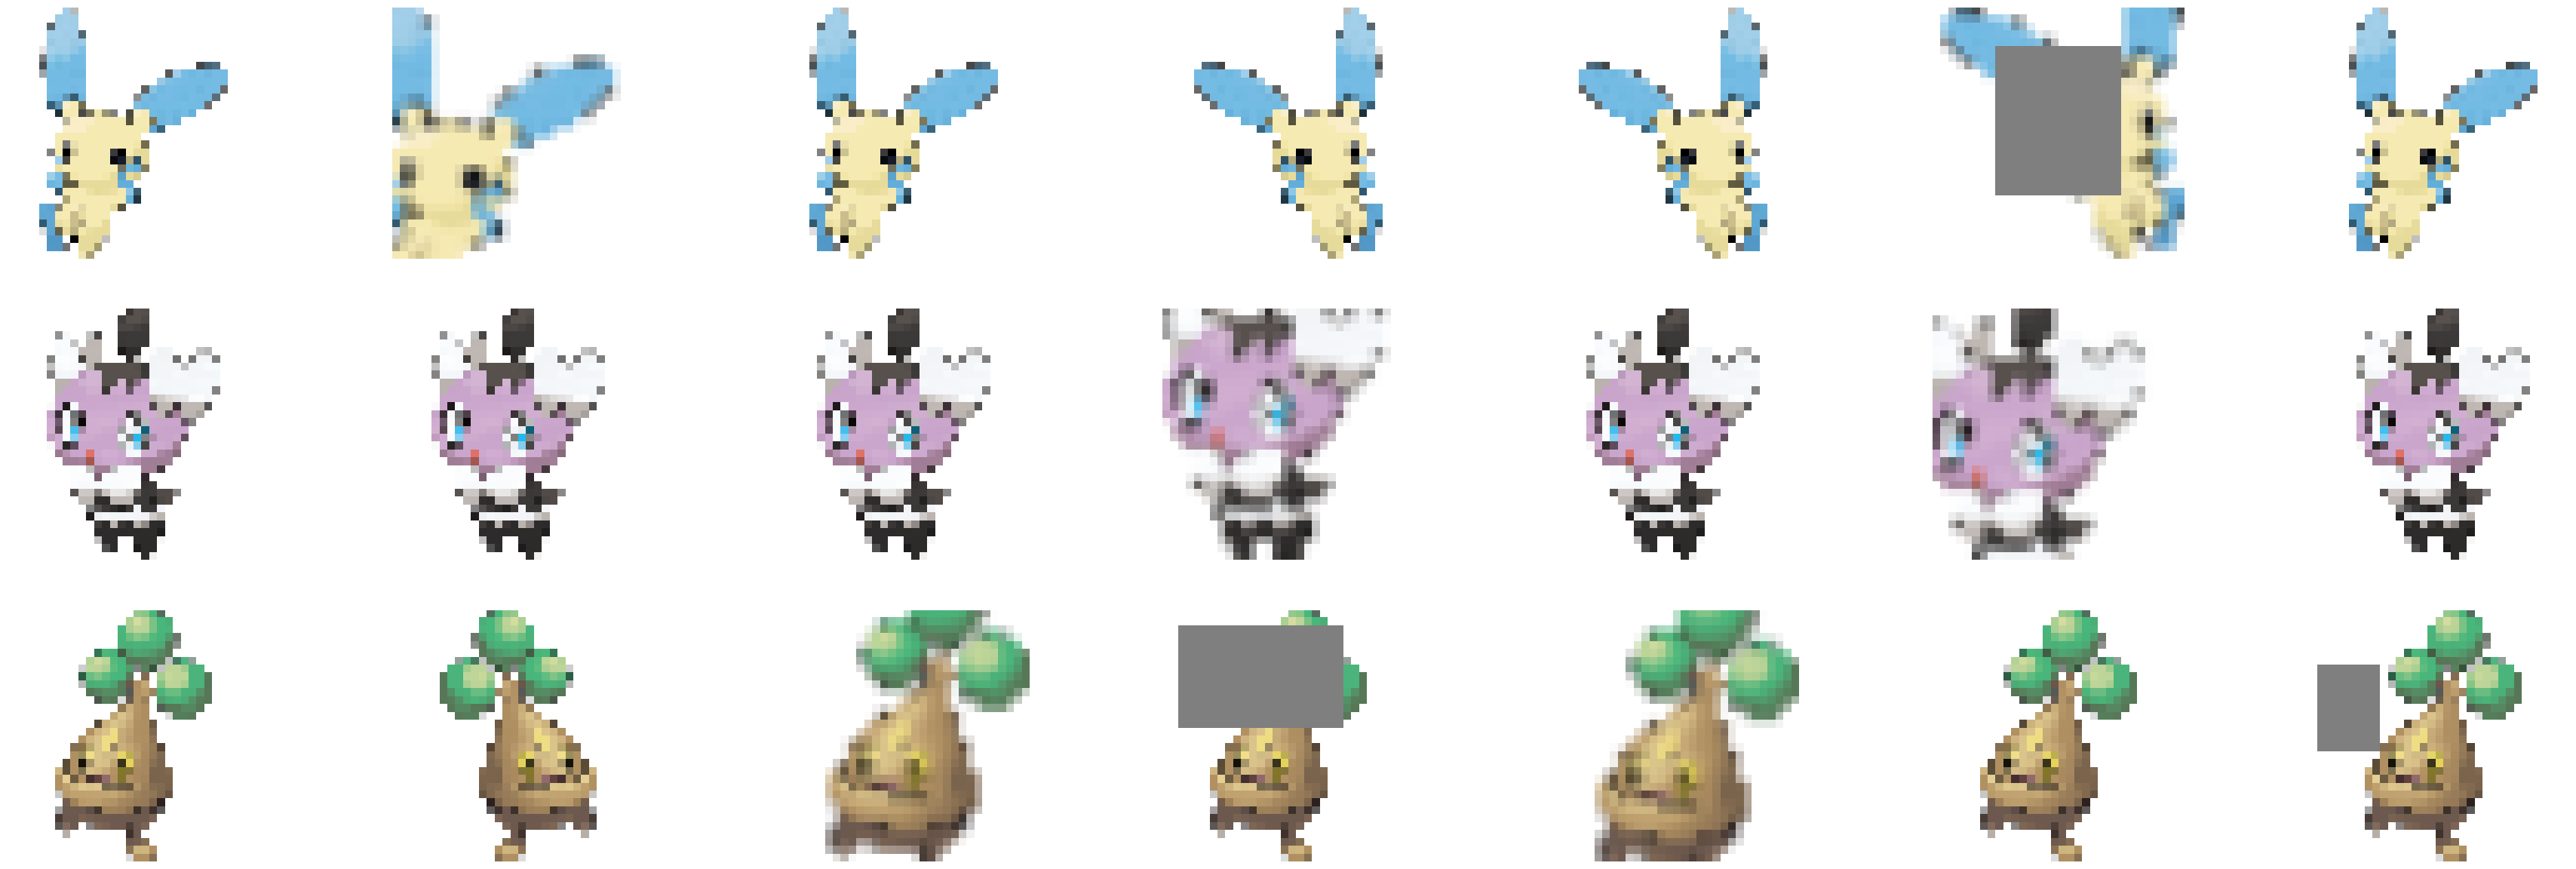

In [ ]:
# Visualize the data

# Show seven versions of the first three Pokemons. 
images_per_row = 7
fig, axes = plt.subplots(3, images_per_row, figsize=(45, 15))

# Plotting each image in a subplot
for i, ax in enumerate(axes.flat):
    # The leftmost Pokemon is without augmentation (with_random_augmentation is False).
    with_random_augmentation = False if i % images_per_row == 0 else True
    ax.imshow(dataset.get_pil_image(i//images_per_row, with_random_augmentation=with_random_augmentation))
    ax.axis('off')

plt.savefig('dataset_summary.png', bbox_inches='tight')
plt.show()


Next, we visualize the frequency of each RGB value in the image dataset (before augmentation). After the forward process, this should look like three standard normal distributions.

In [ ]:
# Create giant tensor with all images.
img_num = len(dataset.img_list)
tensor_with_all_images = torch.zeros((img_num, CHANNELS, IMG_SIZE, IMG_SIZE))
for i, img in enumerate(dataset.img_list):
  tensor_with_all_images[i,:,:,:] = img

# Save the pixel values of all images in 1D tensor for each channel. 
pixels_red = tensor_with_all_images[:,0,:,:].flatten().numpy()
pixels_green = tensor_with_all_images[:,1,:,:].flatten().numpy()
pixels_blue = tensor_with_all_images[:,2,:,:].flatten().numpy()

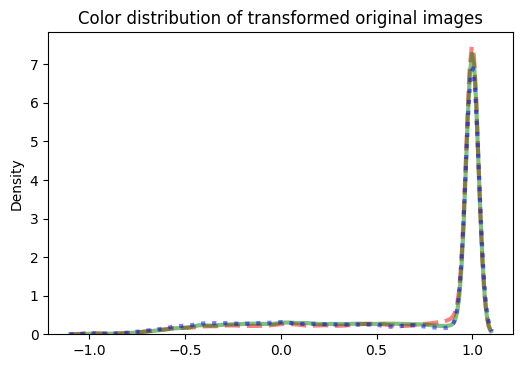

In [ ]:
ax = sns.kdeplot(pixels_red, color="red", alpha=0.5, ls="--", lw=3)
sns.kdeplot(pixels_green, color="green", ax=ax, alpha=0.5, lw=3)
sns.kdeplot(pixels_blue, color="blue", ax=ax, alpha=0.5, ls=":", lw=3)
plt.title("Color distribution of transformed original images")
plt.savefig('color_distribution_original_images.png', dpi=300, bbox_inches='tight')

# Visualizing the Forward Process

<Figure size 600x400 with 0 Axes>

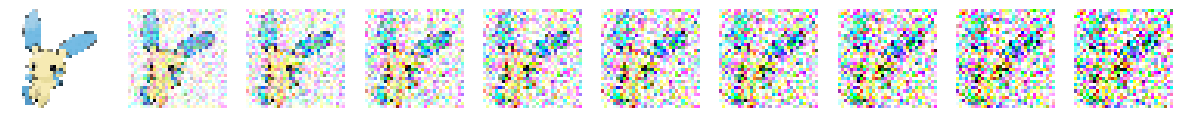

In [ ]:
def one_step_forward(img, t):
  #
  # This is not correct!!! Fix it.
  #
  return img + torch.randn_like(img, device=DEVICE)*0.1

def create_forward_animation(dataset):
  img = dataset.img_list[0].to(DEVICE)
  img_list = list()
  # if TIMESTEPS is too large, you can use a subset
  img_list.append(tensor_to_img(img)) 
  for t in range(TIMESTEPS):
    img = one_step_forward(img, t=t)
    img_list.append(tensor_to_img(img)) 
  return img_list
  
img_list = create_forward_animation(dataset)

# the .gif file can get pretty large
imageio.mimsave("forward_animate.gif", img_list, fps=10) 
# we can also show the images inline
show_from_image_list(img_list, filename = 'forward_grid.png')
